In [1]:
include("LiPoSID.jl")

using LinearAlgebra
using HDF5

using DifferentialEquations
using LinearAlgebra

using Statistics

using Plots

In [2]:
function read_drived_evolution(file_name, freq_num)
    h5open(file_name, "r") do fid
        # Access a group named "group_name"
        group = fid[string(freq_num)]
        # Read a dataset within this group
        p0 = read(group["p0"])
        p1 = read(group["p1"])
        s_re = read(group["s_re"])
        s_im = read(group["s_im"])
        t = read(group["t"])

        n = length(t)
        ρ = [zeros(2, 2)+im*zeros(2, 2) for _ in 1:n]

        for i in [1:n;]
            ρ[i] = Hermitian([ p0[i]               s_re[i]+im*s_im[i]
                               s_re[i]-im*s_im[i]  p1[i]              ])
        end

        return t, ρ
    end
end

function simulate_bloch(H0, V, J, ρ0, tmax, dt, freq_num)
    # Constants and Hamiltonian as defined in your setup


    qubit_freq = 25.133
    w = 2 * qubit_freq * (freq_num-1) / 50

    L(ρ) = J * ρ * J' - 0.5 * (J' * J * ρ + ρ * J' * J)
    Ht(t) = H0 + V * sin(w * t)

    # Define the differential equation
    function matrix_ode!(dρ, ρ, p, t)
        dρ .= -im * (Ht(t) * ρ - ρ * Ht(t)) + L(ρ)
    end

    # Time span
    tspan = (0.0, tmax)

    # Create an ODE problem
    prob = ODEProblem(matrix_ode!, ρ0, tspan)

    # Solve the ODE using a suitable solver, e.g., Tsit5 for non-stiff problems
    sol = solve(prob, Tsit5(), dt=dt, adaptive = false)

    # Access solution
    ρ_solution = sol.u
    t_solution = sol.t;

    b = LiPoSID.bloch(ρ_solution)

    return(b, ρ_solution, t_solution)

end 

simulate_bloch (generic function with 1 method)

In [3]:
function bloch4(ρ_list::Vector{Any})#Vector{Hermitian{ComplexF64, Matrix{ComplexF64}}})
    # Pauli matricies
    σ = [ [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1] ]
    time_steps = length(ρ_list)
    bloch_vec = zeros(4, time_steps)
    for t in 1:time_steps
        bloch_vec[:, t] = [real(tr(σ[i] * ρ_list[t])) for i=1:4] # 2 ???
    end
    convert.(Float64, bloch_vec)
end

function bloch4(ρ_list::Union{Vector{Any},Vector{Matrix{ComplexF64}}})
    # ρ_list::Vector{Matrix{ComplexF64}}
    # Pauli matricies
    σ = [ [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1] ]
    
    time_steps = length(ρ_list)
    bloch_vec = zeros(4, time_steps)
    for t in 1:time_steps
        bloch_vec[:, t] = [real(tr(σ[i] * ρ_list[t])) for i=1:4] # 2 ???
    end
    convert.(Float64, bloch_vec)
end

function simulate_bloch4(H0, V, J, ρ0, tmax, dt, freq_num)
    # Constants and Hamiltonian as defined in your setup


    qubit_freq = 25.133
    w = 2 * qubit_freq * (freq_num-1) / 50

    L(ρ) = J * ρ * J' - 0.5 * (J' * J * ρ + ρ * J' * J)
    Ht(t) = H0 + V * sin(w * t)

    # Define the differential equation
    function matrix_ode!(dρ, ρ, p, t)
        dρ .= -im * (Ht(t) * ρ - ρ * Ht(t)) + L(ρ)
    end

    # Time span
    tspan = (0.0, tmax)

    # Create an ODE problem
    prob = ODEProblem(matrix_ode!, ρ0, tspan)

    # Solve the ODE using a suitable solver, e.g., Tsit5 for non-stiff problems
    sol = solve(prob, Tsit5(), dt=dt, adaptive = false)

    # Access solution
    ρ_solution = sol.u
    t_solution = sol.t;

    b = bloch4(ρ_solution)

    return(b, ρ_solution, t_solution)

end 

simulate_bloch4 (generic function with 1 method)

In [4]:
H0 = [25.133       0.0 + 0.0im
      0.0 - 0.0im  -25.133         ]/2

V0 = 1.

V =  V0 * [0 1
           1 0]

J = [0  sqrt(0.25133)
     0  0            ]

2×2 Matrix{Float64}:
 0.0  0.501328
 0.0  0.0

In [5]:
function simulate_4_blochs(H0, V, J, freq_num)

    tₑₓ0, ρₑₓ0 = read_drived_evolution("DATA/State_B0_SIN_DRIVE_data.h5", string(freq_num))
    tₑₓ1, ρₑₓ1 = read_drived_evolution("DATA/State_B1_SIN_DRIVE_data.h5", string(freq_num))
    tₑₓx, ρₑₓx = read_drived_evolution("DATA/State_BX_SIN_DRIVE_data.h5", string(freq_num))
    tₑₓy, ρₑₓy = read_drived_evolution("DATA/State_BY_SIN_DRIVE_data.h5", string(freq_num))

    dt = tₑₓ0[2]-tₑₓ0[1]

    b0, ρ0, t0 = simulate_bloch(H0, V, J, ρₑₓ0[1], tₑₓ0[end], dt, freq_num-1)
    b1, ρ1, t1 = simulate_bloch(H0, V, J, ρₑₓ1[1], tₑₓ1[end], dt, freq_num-1)
    bx, ρx, tx = simulate_bloch(H0, V, J, ρₑₓx[1], tₑₓx[end], dt, freq_num-1)
    by, ρy, ty = simulate_bloch(H0, V, J, ρₑₓy[1], tₑₓy[end], dt, freq_num-1)

    l_max = min(length(tₑₓ0), length(tₑₓ1), length(tₑₓx), length(tₑₓy))

    return vcat(b0[:,1:l_max], b1[:,1:l_max], bx[:,1:l_max], by[:,1:l_max]), collect(tₑₓ0[1]:dt:tₑₓ0[l_max])
end

function simulate_4_blochs_4(H0, V, J, freq_num)

    tₑₓ0, ρₑₓ0 = read_drived_evolution("DATA/State_B0_SIN_DRIVE_data.h5", string(freq_num))
    tₑₓ1, ρₑₓ1 = read_drived_evolution("DATA/State_B1_SIN_DRIVE_data.h5", string(freq_num))
    tₑₓx, ρₑₓx = read_drived_evolution("DATA/State_BX_SIN_DRIVE_data.h5", string(freq_num))
    tₑₓy, ρₑₓy = read_drived_evolution("DATA/State_BY_SIN_DRIVE_data.h5", string(freq_num))

    dt = tₑₓ0[2]-tₑₓ0[1]

    b0, ρ0, t0 = simulate_bloch4(H0, V, J, ρₑₓ0[1], tₑₓ0[end], dt, freq_num-1)
    b1, ρ1, t1 = simulate_bloch4(H0, V, J, ρₑₓ1[1], tₑₓ1[end], dt, freq_num-1)
    bx, ρx, tx = simulate_bloch4(H0, V, J, ρₑₓx[1], tₑₓx[end], dt, freq_num-1)
    by, ρy, ty = simulate_bloch4(H0, V, J, ρₑₓy[1], tₑₓy[end], dt, freq_num-1)

    l_max = min(length(tₑₓ0), length(tₑₓ1), length(tₑₓx), length(tₑₓy))

    return vcat(b0[:,1:l_max], b1[:,1:l_max], bx[:,1:l_max], by[:,1:l_max]), collect(tₑₓ0[1]:dt:tₑₓ0[l_max])
end

simulate_4_blochs_4 (generic function with 1 method)

In [6]:
freq_num = 25

Y, tspan = simulate_4_blochs_4(H0, V, J, freq_num)

u(t) = V0 * sin(w * t)
qubit_freq = 25.133
w = 2 * qubit_freq * (freq_num-1) / 50
U = [u(t) for t in tspan];


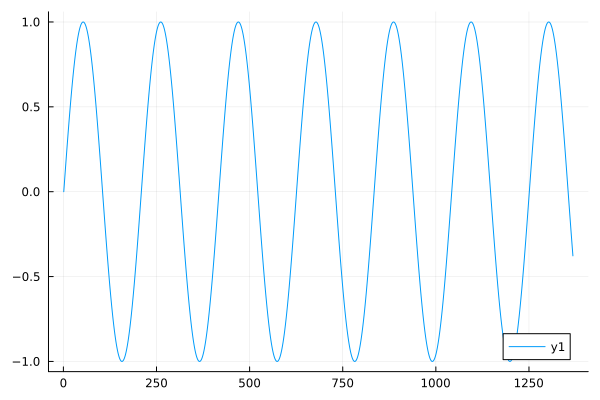

In [7]:
plot(U)

In [8]:
Y

16×1368 Matrix{Float64}:
  0.0   3.78278e-7    3.02516e-6    1.02045e-5   …   0.618856     0.609004
  0.0  -3.61213e-5   -0.000144412  -0.000324663      0.301771     0.319276
  1.0   1.0           1.0           1.0              0.711647     0.712494
  1.0   1.0           1.0           1.0              1.0          1.0
  0.0  -3.7816e-7    -3.02326e-6   -1.01949e-5      -0.260041    -0.24803
  0.0   3.61062e-5    0.000144291   0.000324255  …  -0.377267    -0.384771
 -1.0  -0.999372     -0.998744     -0.998116        -0.171378    -0.171938
  1.0   1.0           1.0           1.0              1.0          1.0
  1.0   0.99935       0.997713      0.995093         0.739087     0.755341
  0.0   0.0314061     0.0627714     0.0940647       -0.53283     -0.509279
  0.0   0.00031487    0.000634174   0.000962428  …   0.00384895   0.00289244
  1.0   1.0           1.0           1.0              1.0          1.0
  0.0   0.0314061     0.0627714     0.0940649       -0.0739371   -0.0562726
 -1.0  -0.999

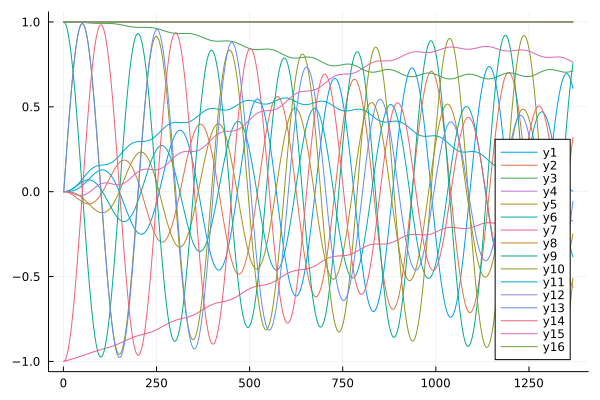

In [9]:
plot(Y')

In [20]:
# Helper function: Column-wise Kronecker product (Khatri-Rao product)

function khatri_rao(U, X)

    if ndims(U) == 1
        U = reshape(U, 1, :)
    end

    # Input: U ∈ R^(Nc×M), X ∈ R^(n×M)
    # Output: U ⊙ X ∈ R^(n*Nc×M)
    Nc, M = size(U)
    n, Mx = size(X)
    if M != Mx
        throw(DimensionMismatch("Number of columns in U and X must match"))
    end

    result = zeros(n * Nc, M)  # Preallocate output matrix
    for j in 1:M
        result[:, j] = vec(kron(U[:, j], X[:, j]))
    end
    return result
end


# Algorithm 1: Bilinear Dynamic Mode Decomposition (biDMD)

"""
Main function: Performs Bilinear Dynamic Mode Decomposition (biDMD) to extract intrinsic dynamics (A) and control dynamics (B).

Inputs:
- X: Snapshot matrix of state data
- X_prime: Shifted snapshot matrix of state data
- U: Control input matrix
- r_tilde: Target rank for SVD on combined matrix Ξ
- r_hat: Target rank for SVD on shifted snapshot matrix X_prime

Outputs:
- Φ: DMD modes
- Λ: DMD eigenvalues
- A_tilde: Intrinsic dynamics matrix (low-rank approximation)
- B_tilde: Control dynamics matrix
"""

function biDMD(X, X_prime, U, r_tilde, r_hat)
    # Step 1: Debug dimensions
    #println("Dimensions of X: ", size(X))
    #println("Dimensions of X_prime: ", size(X_prime))
    #println("Dimensions of U: ", size(U))

    # Compute Khatri-Rao product
    U_kron_X = khatri_rao(U, X)
    #println("Dimensions of U_kron_X (Khatri-Rao): ", size(U_kron_X))

    # Step 2: Construct combined matrix Ξ
    Ξ = vcat(X, U_kron_X)  # Ensure dimensions align
    #println("Dimensions of Ξ: ", size(Ξ))

    # Step 3: Perform truncated SVD on Ξ to rank r_tilde
    U_tilde, Σ_tilde, V_tilde = svd(Ξ)
    U_tilde = U_tilde[:, 1:r_tilde]
    Σ_tilde = Σ_tilde[1:r_tilde]
    V_tilde = V_tilde[:, 1:r_tilde]

    # Decompose U_tilde into U_tilde_A and U_tilde_B
    n = size(X, 1)
    U_tilde_A = U_tilde[1:n, :]
    U_tilde_B = U_tilde[n+1:end, :]

    # Step 4: Compute estimates for A and B
    A_tilde = X_prime * V_tilde * inv(Diagonal(Σ_tilde)) * U_tilde_A'
    B_tilde = X_prime * V_tilde * inv(Diagonal(Σ_tilde)) * U_tilde_B'

    # Step 5: Perform truncated SVD on X_prime to rank r_hat
    U_hat, Σ_hat, V_hat = svd(X_prime)
    U_hat = U_hat[:, 1:r_hat]
    Σ_hat = Σ_hat[1:r_hat]
    V_hat = V_hat[:, 1:r_hat]

    # Step 6: Low-rank approximation for A
    A_hat = U_hat' * A_tilde * U_hat

    # Step 7: Eigendecomposition of A_hat
    W, Λ = eigen(A_hat)

    # Step 8: Compute DMD modes Φ
    Φ = A_tilde * U_hat * W

    return Φ, Λ, A_tilde, B_tilde
end


biDMD (generic function with 1 method)

In [21]:
Φ, Λ, A_tilde, B_tilde = biDMD(Y[:,1:end-1], Y[:,2:end], U[1:end-1], 5, 5)

([0.014177601114952417, 0.02728541954325242, -0.0008548876905883906, -0.0006563575418315412, -0.014942094881700658, -0.026285349248520426, 0.012560647195803697, -0.0006563575418315724, -0.4743102678900148, 0.24485254813890903, 0.019801029206521718, -0.0006563575418314233, 0.24358529802014922, 0.47324489057227836, 0.0026569282248403298, -0.0006563575418315204], [0.0004885376823700653 0.00013313527249403988 … 0.12731605751771438 0.9902153187905697; 0.0008878523389231327 0.0007223089156898883 … -0.12518408045286888 -0.036878542551598656; … ; -0.05898311691894015 -0.998006079531166 … -0.02282170862309205 -0.003221135764308746; 0.9982584280013248 -0.05888175842420135 … -0.0009716973514220062 -0.0005827308278087401], [0.001401118398098217 -7.949584214184785e-6 … 0.0006264427960197104 6.427774034417891e-5; 0.00010105124302983898 0.0017710830421826533 … -0.00019914541222420677 -1.551111053318322e-5; … ; 0.0006156676012332991 -0.00022323249012810235 … 0.0022374194462256927 0.01807192707281614; 

In [12]:
function propagate_system(A, B, x0, U, steps)
    """
    Propagates the system using biDMD matrices A and B.

    Inputs:
    - A: Drift dynamics matrix (from biDMD)
    - B: Control dynamics matrix (from biDMD)
    - x0: Initial state vector (column vector)
    - U: Matrix of control inputs, where each column is u_t
    - steps: Number of time steps to propagate

    Output:
    - Trajectories: Matrix of propagated states, where each column is x_t
    """

    if ndims(U) == 1
        U = reshape(U, 1, :)
    end

    n = size(A, 1)         # State vector dimension
    X = zeros(n, steps)  # Preallocate state trajectory matrix
    X[:, 1] = x0         # Set initial state

    # Propagate the state over time
    for t in 1:(steps - 1)
        #X[:,t+1] = A * X[:, t] + B * khatri_rao(U[:, t], X[:, t])     
        X[:,t+1] = A * X[:, t] + B * vec(kron(U[:, t], X[:, t]))
    end

    return X
end

propagate_system (generic function with 1 method)

In [13]:
Y_sid_0 = Y[:,1]

Y_sid = propagate_system(A_tilde, B_tilde, Y_sid_0, U, size(Y)[2]-1)

16×1367 Matrix{Float64}:
  0.0   0.179022    0.177765     0.188608    …  -2.40969e24  -2.41073e24
  0.0   0.177718    0.157363     0.143594        8.78405e22   5.40054e22
  1.0   0.846452    0.797113     0.771952       -6.63553e23  -6.95329e23
  1.0   0.981449    0.96375      0.942371       -4.62738e23  -4.76795e23
  0.0  -0.0337549  -0.0344137   -0.0424278       1.84819e24   1.83725e24
  0.0  -0.203384   -0.191565    -0.184674    …   3.4548e23    3.72872e23
 -1.0  -0.606725   -0.516243    -0.487287        8.63659e23   9.18717e23
  1.0   0.981449    0.96375      0.942371       -4.62738e23  -4.76795e23
  1.0   0.990656    0.991852     0.995437        1.24938e24   1.13909e24
  0.0   0.0143123   0.00425892  -0.00151892      3.79265e24   3.76547e24
  0.0   0.253527    0.240887     0.229716    …  -1.7525e23   -1.76295e23
  1.0   0.981449    0.96375      0.942371       -4.62738e23  -4.76795e23
  0.0   0.204289    0.20032      0.205978        2.59622e24   2.56286e24
 -1.0  -0.898211   -0.9131

In [14]:
Y

16×1368 Matrix{Float64}:
  0.0   3.78278e-7    3.02516e-6    1.02045e-5   …   0.618856     0.609004
  0.0  -3.61213e-5   -0.000144412  -0.000324663      0.301771     0.319276
  1.0   1.0           1.0           1.0              0.711647     0.712494
  1.0   1.0           1.0           1.0              1.0          1.0
  0.0  -3.7816e-7    -3.02326e-6   -1.01949e-5      -0.260041    -0.24803
  0.0   3.61062e-5    0.000144291   0.000324255  …  -0.377267    -0.384771
 -1.0  -0.999372     -0.998744     -0.998116        -0.171378    -0.171938
  1.0   1.0           1.0           1.0              1.0          1.0
  1.0   0.99935       0.997713      0.995093         0.739087     0.755341
  0.0   0.0314061     0.0627714     0.0940647       -0.53283     -0.509279
  0.0   0.00031487    0.000634174   0.000962428  …   0.00384895   0.00289244
  1.0   1.0           1.0           1.0              1.0          1.0
  0.0   0.0314061     0.0627714     0.0940649       -0.0739371   -0.0562726
 -1.0  -0.999

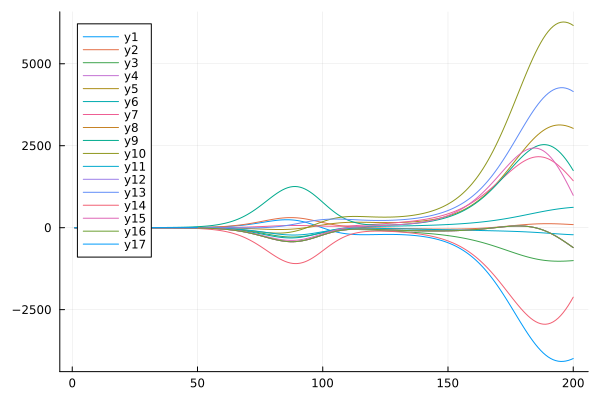

In [15]:
plot(Y_sid[:,1:200]')
plot!(U[1:50])

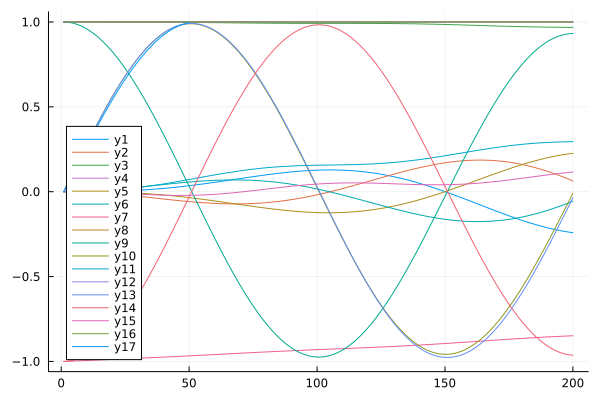

In [16]:
plot(Y[:,1:200]')
plot!(U[1:50])

In [17]:
b0 = Y[1:3,:]
b1 = Y[5:7,:]
bx = Y[8:10,:]
by = Y[11:13,:]

b0_sid = Y_sid[1:3,:]
b1_sid = Y_sid[5:7,:]
bx_sid = Y_sid[8:10,:]
by_sid = Y_sid[11:13,:]

ρ0 = LiPoSID.rho_series_from_bloch(b0)
ρ1 = LiPoSID.rho_series_from_bloch(b1)
ρx = LiPoSID.rho_series_from_bloch(bx)
ρy = LiPoSID.rho_series_from_bloch(by)


ρ0_sid = LiPoSID.rho_series_from_bloch(b0_sid)
ρ1_sid = LiPoSID.rho_series_from_bloch(b1_sid)
ρx_sid = LiPoSID.rho_series_from_bloch(bx_sid)
ρy_sid = LiPoSID.rho_series_from_bloch(by_sid);



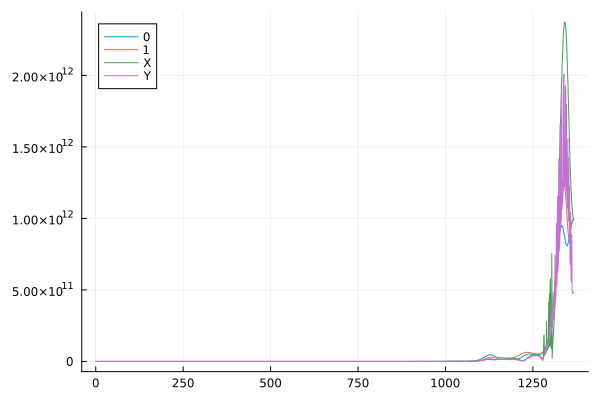

In [18]:
using QuantumOptics

basis = NLevelBasis(2)

F0 = LiPoSID.fidelity_series(basis, ρ0_sid, ρ0)
F1 = LiPoSID.fidelity_series(basis, ρ1_sid, ρ1)
Fx = LiPoSID.fidelity_series(basis, ρx_sid, ρx)
Fy = LiPoSID.fidelity_series(basis, ρy_sid, ρy)

plot(F0, label="0")
plot!(F1, label="1")
plot!(Fx, label="X")
plot!(Fy, label="Y")

In [58]:
function normalize_bloch_vectors(bloch_matrix::AbstractMatrix{<:Real})
    """
    Normalize columns of a 3 x N matrix of Bloch vectors.

    Parameters:
        bloch_matrix::AbstractMatrix: 3 x N matrix where each column is a Bloch vector.

    Returns:
        3 x N matrix of normalized Bloch vectors.
    """
    bloch_normal = [bloch_matrix[:, i]/norm(bloch_matrix[:, i])' for i in 1:size(bloch_matrix, 2)]
    
    return hcat(bloch_normal...)   # Element-wise division by norms
end

normalize_bloch_vectors (generic function with 1 method)

In [59]:
normalize_bloch_vectors(Y_sid[1:3,:])

3×2546 Matrix{Float64}:
 0.0  -1.6445e-8   -1.31543e-7  -4.438e-7    …  -0.00356214  -0.00330948
 0.0   1.57063e-6   6.27986e-6   1.41233e-5     -0.0079099   -0.00815789
 1.0   1.0          1.0          1.0             0.999962     0.999961

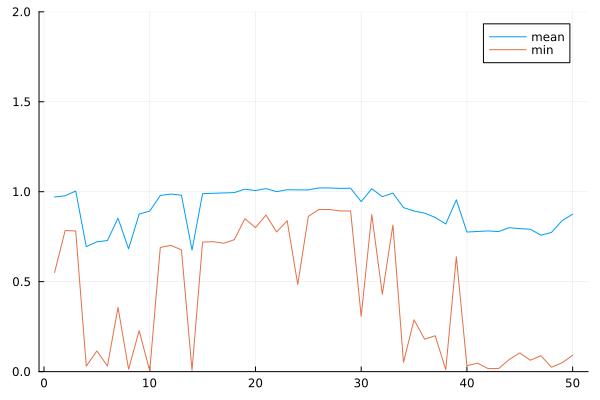

In [60]:
model_rank = 16

Fs = []

Fmeans = []
Fmins = []

for freq_num in 1:50

    Y, tspan = simulate_4_blochs_4(H0, V, J, freq_num)

    u(t) = V0 * sin(w * t)
    qubit_freq = 25.133
    w = 2 * qubit_freq * (freq_num-1) / 50
    U = [u(t) for t in tspan]

    Φ, Λ, A_tilde, B_tilde = biDMD(Y[:,1:end-1], Y[:,2:end], U[1:end-1], model_rank, model_rank)

    Y_sid = propagate_system(A_tilde, B_tilde, Y[:,1], U, size(Y)[2]-1)

    b0 = Y[1:3,:]
    b1 = Y[5:7,:]
    bx = Y[8:10,:]
    by = Y[11:13,:]
    
    b0_sid = normalize_bloch_vectors(Y_sid[1:3,:])
    b1_sid = normalize_bloch_vectors(Y_sid[5:7,:])
    bx_sid = normalize_bloch_vectors(Y_sid[8:10,:])
    by_sid = normalize_bloch_vectors(Y_sid[11:13,:])

    ρ0 = LiPoSID.rho_series_from_bloch(b0)
    ρ1 = LiPoSID.rho_series_from_bloch(b1)
    ρx = LiPoSID.rho_series_from_bloch(bx)
    ρy = LiPoSID.rho_series_from_bloch(by)


    ρ0_sid = LiPoSID.rho_series_from_bloch(b0_sid)
    ρ1_sid = LiPoSID.rho_series_from_bloch(b1_sid)
    ρx_sid = LiPoSID.rho_series_from_bloch(bx_sid)
    ρy_sid = LiPoSID.rho_series_from_bloch(by_sid)

    F0 = LiPoSID.fidelity_series(basis, ρ0_sid, ρ0)
    F1 = LiPoSID.fidelity_series(basis, ρ1_sid, ρ1)
    Fx = LiPoSID.fidelity_series(basis, ρx_sid, ρx)
    Fy = LiPoSID.fidelity_series(basis, ρy_sid, ρy)

    push!(Fs, [F0..., F1 ..., Fx..., Fy...])

    push!(Fmeans, mean([F0..., F1 ..., Fx..., Fy...]))
    push!(Fmins, minimum([F0..., F1 ..., Fx..., Fy...]))

end

plot(Fmeans, label="mean")
plot!(Fmins, label="min")
ylims!(0, 2)

In [33]:
using StatsPlots

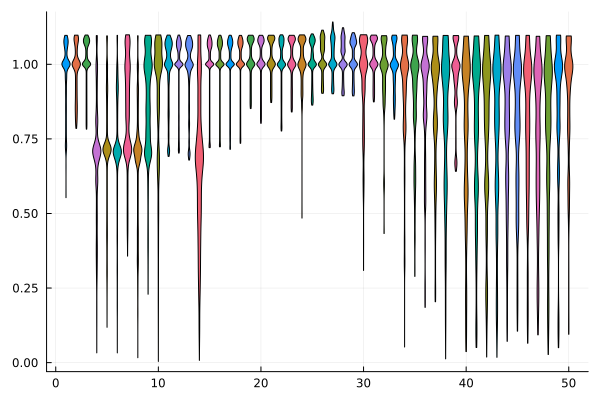

In [62]:
violin(Fs)
#ylims!(-1, 10)
plot!(legend = false)

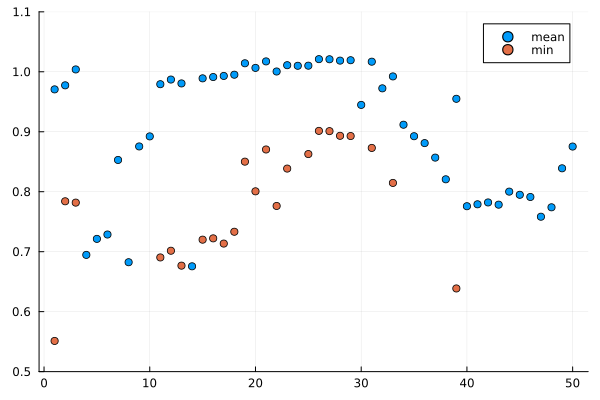

In [64]:
plot(Fmeans, label="mean", seriestype=:scatter)
plot!(Fmins, label="min", seriestype=:scatter)
ylims!(0.5, 1.1)